## Finetuning the iNaturalist model using an architecture capable of predicting multiple labels per image (use of V3 dataset)

First download V3 dataset

In [1]:
# check metadata csv file (dataset-v3.csv) is in google drive

# mount google drive
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

# peek contents of dataset-v3.csv
!head /content/drive/MyDrive/team_challenge/dataset-v3.csv

Mounted at /content/drive
"annotation_id","annotator","choice","created_at","id","image","lead_time","updated_at"
313,"4","Grass","2024-07-11T10:12:24.449200Z",18194,"/data/local-files/?d=content/content/flat_split/Bare%20Soil_Fran_0_194_388.jpg",4.744,"2024-07-11T10:12:24.449230Z"
346,"4","{""choices"":[""Grass"",""Artifact""]}","2024-07-11T10:14:02.288312Z",18212,"/data/local-files/?d=content/content/flat_split/Bare%20Soil_Fran_0_2419_388.jpg",16.121,"2024-07-11T10:14:02.288342Z"
363,"4","{""choices"":[""Grass"",""Soil""]}","2024-07-11T10:14:38.518648Z",18221,"/data/local-files/?d=content/content/flat_split/Bare%20Soil_Fran_0_388_965.jpg",4.318,"2024-07-11T10:14:38.518677Z"
376,"4","{""choices"":[""Grass"",""Soil""]}","2024-07-11T10:15:08.588492Z",18226,"/data/local-files/?d=content/content/flat_split/Bare%20Soil_Fran_0_582_776.jpg",3.141,"2024-07-11T10:15:08.588532Z"
385,"4","{""choices"":[""Grass"",""Soil""]}","2024-07-11T10:15:31.489451Z",18230,"/data/local-files/?d=content/conten

In [2]:
import json

def parse_json_choice(json_string):
  # Return the choices in form of a list e.g.:
  # input: '{"choices":["Grass","Soil"]}'
  # output: ["Grass","Soil"]
  json_data = json.loads(json_string)

  return json_data['choices']

In [3]:
# Generate df

import pandas as pd

csv_path = "/content/drive/MyDrive/team_challenge/dataset-v3.csv"
main_df = pd.read_csv(csv_path)

# make image name column
main_df['image_name'] = main_df['image'].apply(lambda x: x.split('/')[-1].replace('%20', ' ')) # Ensure URL encoded spaces are replaced

# parse 'choice' column to assign labels to images (nb images can have more than one label)
df_labels = []
for index, row in main_df.iterrows():
  if type(row['choice']) != str:
    df_labels.append(None)
  elif '{"choices":' in row['choice']:
    label_list = parse_json_choice(row['choice']) # row choices a list e.g. ['Grass', 'Soil']
    df_labels.append(label_list)
  else:
    df_labels.append([row['choice']])

main_df['label'] = df_labels

# Drop images with no labels
main_df_noNaN = main_df.dropna(subset=['label'])
print(f"{len(main_df) - len(main_df_noNaN)} images with no labels removed")

main_df_noNaN

68 images with no labels removed


,annotation_id,annotator,choice,created_at,id,image,lead_time,updated_at,image_name,label
0,313,4,Grass,2024-07-11T10:12:24.449200Z,18194,/data/local-files/?d=content/content/flat_spli...,4.744,2024-07-11T10:12:24.449230Z,Bare Soil_Fran_0_194_388.jpg,[Grass]
1,346,4,"{""choices"":[""Grass"",""Artifact""]}",2024-07-11T10:14:02.288312Z,18212,/data/local-files/?d=content/content/flat_spli...,16.121,2024-07-11T10:14:02.288342Z,Bare Soil_Fran_0_2419_388.jpg,"[Grass, Artifact]"
2,363,4,"{""choices"":[""Grass"",""Soil""]}",2024-07-11T10:14:38.518648Z,18221,/data/local-files/?d=content/content/flat_spli...,4.318,2024-07-11T10:14:38.518677Z,Bare Soil_Fran_0_388_965.jpg,"[Grass, Soil]"
3,376,4,"{""choices"":[""Grass"",""Soil""]}",2024-07-11T10:15:08.588492Z,18226,/data/local-files/?d=content/content/flat_spli...,3.141,2024-07-11T10:15:08.588532Z,Bare Soil_Fran_0_582_776.jpg,"[Grass, Soil]"
4,385,4,"{""choices"":[""Grass"",""Soil""]}",2024-07-11T10:15:31.489451Z,18230,/data/local-files/?d=content/content/flat_spli...,3.113,2024-07-11T10:15:31.489485Z,Bare Soil_Fran_0_776_388.jpg,"[Grass, Soil]"
...,...,...,...,...,...,...,...,...,...,...
14617,8313,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T12:19:27.506188Z,114568,/data/local-files/?d=content/content/flat_spli...,1.795,2024-07-17T12:19:27.506207Z,More Clover_9_0_1746.jpg,"[Clover, Grass]"
14618,8281,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T12:12:20.629833Z,114600,/data/local-files/?d=content/content/flat_spli...,9.405,2024-07-17T12:12:20.629851Z,More Clover_9_194_1552.jpg,"[Clover, Grass]"
14619,8268,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T12:09:18.940466Z,114613,/data/local-files/?d=content/content/flat_spli...,2.428,2024-07-17T12:09:18.940483Z,More Clover_9_388_1824.jpg,"[Clover, Grass]"
14620,8247,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T12:08:02.035190Z,114634,/data/local-files/?d=content/content/flat_spli...,2.586,2024-07-17T12:08:02.035208Z,More Clover_9_776_1746.jpg,"[Clover, Grass]"


In [4]:
# downsample grass to balance dataset (target = 50% grass)
# See 240722_datasetV3_exploration.ipynb for breakdown

from sklearn.utils import resample

df_grass_only = main_df_noNaN[main_df_noNaN['label'].apply(lambda x: x == ['Grass'])]
df_not_grass_only = main_df_noNaN[main_df_noNaN['label'].apply(lambda x: x != ['Grass'])]

target_grass_count = len(df_grass_only)//2 # half the number of grass only images

df_grass_downsampled = resample(df_grass_only,
                              replace=False,
                              n_samples=target_grass_count,
                              random_state=0)

print(f"Number of grass (only) images before/after = {len(df_grass_only)}/{len(df_grass_downsampled)}")

main_df_resampled = pd.concat([df_grass_downsampled, df_not_grass_only])

print(f"Size of dataset before/after downsampling = {len(main_df_noNaN)}/{len(main_df_resampled)}")

main_df_resampled

Number of grass (only) images before/after = 9213/4606
Size of dataset before/after downsampling = 14554/9947


,annotation_id,annotator,choice,created_at,id,image,lead_time,updated_at,image_name,label
10432,4336,10,Grass,2024-07-16T12:50:20.184250Z,57698,/data/local-files/?d=content/content/flat_spli...,1.488,2024-07-16T12:50:20.184271Z,Cow Dung_Stev_434_1312_0.jpg,[Grass]
11514,1043,3,Grass,2024-07-12T09:30:22.073600Z,70143,/data/local-files/?d=content/content/flat_spli...,1.674,2024-07-12T09:30:22.073631Z,Dock Leaves_Leon_576_582_194.jpg,[Grass]
8121,1817,5,Grass,2024-07-13T16:31:44.716468Z,38592,/data/local-files/?d=content/content/flat_spli...,2.454,2024-07-13T16:31:44.716486Z,Clover_Livia_229_1164_776.jpg,[Grass]
6652,699,3,Grass,2024-07-11T10:32:01.287563Z,91975,/data/local-files/?d=content/content/flat_spli...,1.691,2024-07-11T10:32:01.287593Z,Sheep Dung_Livia_819_582_970.jpg,[Grass]
13765,11611,5,Grass,2024-07-17T15:03:40.400389Z,113866,/data/local-files/?d=content/content/flat_spli...,12.249,2024-07-17T15:03:40.400408Z,More Clover_20_0_194.jpg,[Grass]
...,...,...,...,...,...,...,...,...,...,...
14617,8313,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T12:19:27.506188Z,114568,/data/local-files/?d=content/content/flat_spli...,1.795,2024-07-17T12:19:27.506207Z,More Clover_9_0_1746.jpg,"[Clover, Grass]"
14618,8281,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T12:12:20.629833Z,114600,/data/local-files/?d=content/content/flat_spli...,9.405,2024-07-17T12:12:20.629851Z,More Clover_9_194_1552.jpg,"[Clover, Grass]"
14619,8268,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T12:09:18.940466Z,114613,/data/local-files/?d=content/content/flat_spli...,2.428,2024-07-17T12:09:18.940483Z,More Clover_9_388_1824.jpg,"[Clover, Grass]"
14620,8247,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T12:08:02.035190Z,114634,/data/local-files/?d=content/content/flat_spli...,2.586,2024-07-17T12:08:02.035208Z,More Clover_9_776_1746.jpg,"[Clover, Grass]"


In [5]:
# Download images zips
!wget https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/data.zip
!wget https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/more_clover_fragments.zip


--2024-07-25 13:30:27--  https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/data.zip
Resolving sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (sensor-cdt-group-project.s3.eu-north-1.amazonaws.com)... 16.12.9.6, 3.5.217.57
Connecting to sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (sensor-cdt-group-project.s3.eu-north-1.amazonaws.com)|16.12.9.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751308166 (1.6G) [binary/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.63G  13.4MB/s    in 2m 6s   

2024-07-25 13:32:35 (13.2 MB/s) - ‘data.zip’ saved [1751308166/1751308166]

--2024-07-25 13:32:35--  https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/more_clover_fragments.zip
Resolving sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (sensor-cdt-group-project.s3.eu-north-1.amazonaws.com)... 16.12.10.14, 3.5.218.51
Connecting to sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (sensor-cdt-

In [6]:
# Make dir to store images & unzip
!mkdir -p finetune_data
!unzip -q data.zip -d finetune_data
!unzip -q more_clover_fragments.zip -d finetune_data/content/ # more clover fragments zip has one less directory depth

In [7]:
# count number of downloaded images
!ls -l finetune_data/content/content/flat_split/ | wc -l

96497


Prepare data for finetuning.  
NB:  
- Added one-hot encoding to enable multilabel classification task
- New label class added (Sheep Dung) for a total of 6 classes


In [8]:
# define dataset class

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os


class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {'Grass': 0, 'Clover': 1, 'Soil': 2, 'Dung': 3, 'Sheep Dung': 4, 'Artifact': 5} # NB 6 classes
        self.num_classes = len(self.label_map)
        self.class_names = list(self.label_map.keys())
        self.image_paths = [os.path.join(self.img_dir, img_name) for img_name in self.dataframe.iloc[:, 8]]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        image = Image.open(img_name).convert("RGB")

        label_indices = [self.label_map[label] for label in self.dataframe.iloc[idx, 9]] # extracts labels associated with the image (can be one or more)
        label_tensor = torch.tensor(label_indices, dtype=torch.long)

        label_onehot = nn.functional.one_hot(label_tensor, num_classes=self.num_classes)
        label_onehot = label_onehot.max(dim=0)[0].float()

        if self.transform:
            image = self.transform(image)

        return image, label_onehot

    def get_image_path(self, idx):
        return self.image_paths[idx]

    def get_labels(self, idx):
        return self.dataframe.iloc[idx, 9]

# define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Create dataset object

img_dir = 'finetune_data/content/content/flat_split/'

dataset = CustomDataset(dataframe=main_df_resampled, img_dir=img_dir, transform=transform)

label_map = dataset.label_map

In [10]:
def onehot_to_labels(onehot_label_tensor, class_names):
    """
    Convert a one-hot encoded label tensor to a list of label names.
    """
    # Ensure the input is a tensor
    if not isinstance(onehot_label_tensor, torch.Tensor):
        raise TypeError("Input should be a torch.Tensor")

    # Convert the one-hot tensor to a list of indices where value is 1
    active_indices = torch.where(onehot_label_tensor > 0.5)[0].tolist() # threshold of 0.5

    # Map indices to label names
    labels = [class_names[idx] for idx in active_indices]

    return labels

One-hot encoding: tensor([1., 1., 0., 0., 0., 0.])
Label: ['Grass', 'Clover']


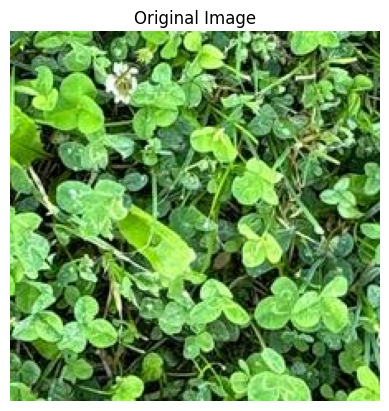

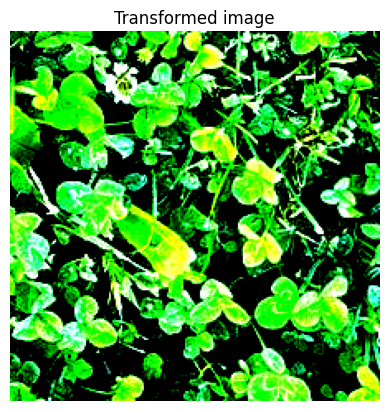

In [11]:
# Show an example image from the dataset

import numpy as np
import matplotlib.pyplot as plt
import cv2

image_index = 9946 # pick an image to display

data = dataset[image_index]
class_names = [label for label in label_map.keys()]

image, onehot_label_tensor = data[0], data[1]
image_label = onehot_to_labels(onehot_label_tensor, class_names)  # Access class_name from the original dataset

# Convert tensor image to numpy for plotting
img_np = np.transpose(image.numpy(), (1, 2, 0))

# Obtain the path of the plotted image
image_path = dataset.get_image_path(image_index)  # Access get_image_path method from the original dataset

# Read the original image using OpenCV
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Obtain the label of the plotted image
print(f"One-hot encoding: {onehot_label_tensor}")
print(f"Label: {image_label}")

# Plot the original image
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')
plt.show()

# Plot transformed image
plt.title("Transformed image")
plt.imshow(img_np)
plt.axis('off')
plt.show()


In [12]:
# Perform train, val split and create DataLoaders

from torch.utils.data import DataLoader, random_split

torch.manual_seed(42) # for reproducible splitting

# Split the dataset into train and validation sets (80/20 split)
train_set, val_set = random_split(dataset, [0.8, 0.2])

# Create DataLoaders for each set
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# Print dataset sizes
print(f'Train set size: {len(train_set)}')
print(f'Validation set size: {len(val_set)}')

Train set size: 7958
Validation set size: 1989


Download iNaturalist model weights, select resnet50 architecture (https://github.com/visipedia/newt/tree/main/benchmark), and prepare for finetuning

In [16]:
# First go to this dropbox (https://cornell.app.box.com/s/bnyhq5lwobu6fgjrub44zle0pyjijbmw) and generate download popup to get link to wget weights
!wget "https://public.boxcloud.com/d/1/b1!3Z0upc2A5cypeQ0jLM_4VdOOipj-Ly9XBw9vwApZMmGtkBrqG0WmOT6IoXK0ca_0XYcvsK_wi20nuuzq3uziBmvAJ7foovxyaqKcy24K7VZD5PZ2ts18g6M07L6T1Bm-pv135EEilYVwkbCGPrxDWSBdGwdBt8pJgDcKzqAClxsN0iriSwUoT3ZdI76K8xdmebz_vFflaVdcgbLiyeIrraoQQb5so_uNmWPk4x9q17S6GmUVG88xW6H3frWXkizdaEyySlTt5MnGR76hBAU-V43PZKZmAZfplm7KHb3yD5h6wwP6YQjAjx7FBNUysdpQtBj98vExDYeOZUcCb1PLFbYw-hpjM8m3S35_0ymWLiusK2h3OYe_z-pwD8hJbtrQgFLqGeUp3OWmMqd3RKC96ZuZO1-99Eh0ruL1DrydgQGKHpfkljKgB0j6HUZgNA5ylAMsk2sBVRmxnze8elKSr7GJDk6EQ8Tf9NtKuDOLoRHpMipCvwV77ELeyEv6aERb_xMos27tLvsYvHA0SqcRxMWF9WOv1gzZFqxIV__qLzyd3S9zS1nECWg4I4lQBI4WJ1F_JDuXOrQjMu-V-08vSMZEMMIfJmrU0kMybOLxOFSK2G-XOtd9VOmqvmzjo4C-h0mNNUv5DK9-yge3CKq8V21lTk59ck8VLCnwpNKBGyFDpCOhVlMrCBn3JuVfSEUcyGQCvK99jNggOtmJW6nQNwPs5rbmOMTW4nbE2r7crX8dMhNGTg9cPoSYwXk3UzQ7Fw1dIHqL4I7dizyGttLeWAkzOpVVOvzUT_j5rB7_EciF67SnlAjj-0SoS6sqMjCQN4KaEX3-Dxp-dPz4iNrPfdjLAlplqylTndT4eenzueGBkqEBvv8o9k-GZwLxhxfscJfVv2Couy1CaNYoqbor1KH4SXxOVRZ_WFREag6kzCXlLy-G8s-g-bJyxVjw8SU515OlXXt_1l-iaerwqNs2p9BC9YhdQXAyHf7MJasRAN5W2ga12nf0c1wX-5kZpIlcc11p40PtshDb2wHJSX1TfYEnl2avRGeBCM8zG0Sx-9QqZ9oBNrij0VwdrvGJr8vWWmD6rfVUyyIMFMjx7d4_wCBiLWkarH4YDCPaRmFbTWlnDaOWRsNiDWEF9GGmgyLacIxcMNKqddmNqPrcnnTgracDhpSrLfyOyOsvUgJPitx6xRK7fGgODZFcsrGbwOPlF1BaWtbyOEY7iFzwYq7pD7Tx4C_77z0syRz3gGBX9O71zG-stORuCZ_T5tWxtRtFpJG4ScfffU2x1CnzNvjdpUBz9A9Nzw../download" -O cvpr21_newt_pretrained_models.tar.gz

--2024-07-25 13:34:10--  https://public.boxcloud.com/d/1/b1!3Z0upc2A5cypeQ0jLM_4VdOOipj-Ly9XBw9vwApZMmGtkBrqG0WmOT6IoXK0ca_0XYcvsK_wi20nuuzq3uziBmvAJ7foovxyaqKcy24K7VZD5PZ2ts18g6M07L6T1Bm-pv135EEilYVwkbCGPrxDWSBdGwdBt8pJgDcKzqAClxsN0iriSwUoT3ZdI76K8xdmebz_vFflaVdcgbLiyeIrraoQQb5so_uNmWPk4x9q17S6GmUVG88xW6H3frWXkizdaEyySlTt5MnGR76hBAU-V43PZKZmAZfplm7KHb3yD5h6wwP6YQjAjx7FBNUysdpQtBj98vExDYeOZUcCb1PLFbYw-hpjM8m3S35_0ymWLiusK2h3OYe_z-pwD8hJbtrQgFLqGeUp3OWmMqd3RKC96ZuZO1-99Eh0ruL1DrydgQGKHpfkljKgB0j6HUZgNA5ylAMsk2sBVRmxnze8elKSr7GJDk6EQ8Tf9NtKuDOLoRHpMipCvwV77ELeyEv6aERb_xMos27tLvsYvHA0SqcRxMWF9WOv1gzZFqxIV__qLzyd3S9zS1nECWg4I4lQBI4WJ1F_JDuXOrQjMu-V-08vSMZEMMIfJmrU0kMybOLxOFSK2G-XOtd9VOmqvmzjo4C-h0mNNUv5DK9-yge3CKq8V21lTk59ck8VLCnwpNKBGyFDpCOhVlMrCBn3JuVfSEUcyGQCvK99jNggOtmJW6nQNwPs5rbmOMTW4nbE2r7crX8dMhNGTg9cPoSYwXk3UzQ7Fw1dIHqL4I7dizyGttLeWAkzOpVVOvzUT_j5rB7_EciF67SnlAjj-0SoS6sqMjCQN4KaEX3-Dxp-dPz4iNrPfdjLAlplqylTndT4eenzueGBkqEBvv8o9k-GZwLxhxfscJfVv2Couy1CaNYoqbor1KH4SXxOVRZ_WFREag6kzCXl

In [17]:
# Unzip models
!tar -xzf cvpr21_newt_pretrained_models.tar.gz

In [18]:
# Load target model (inat2021_supervised_large)

import torch
from torchvision.models import resnet50

def load_iNaturalist_model():

  model = resnet50()
  num_iNaturalist_classes = 10000 # 10,000 classes including all species
  model.fc = torch.nn.Linear(in_features=2048, out_features=num_iNaturalist_classes)

  weights_file_path = "cvpr21_newt_pretrained_models/pt/inat2021_supervised_large.pth.tar"
  checkpoint = torch.load(weights_file_path, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['state_dict'])

  return model

model = load_iNaturalist_model()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# Modify the output layer for multilabel classification with the new number of classes

new_num_classes = 6  # {Clover, Grass, Dung, Sheep Dung, Soil, Artifact}

# Define a new class to wrap the model with a sigmoid activation
class MultiLabelResNet(torch.nn.Module):
    def __init__(self, original_model, num_classes):
        super(MultiLabelResNet, self).__init__()
        self.resnet = original_model
        self.resnet.fc = torch.nn.Linear(in_features=2048, out_features=num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        x = self.sigmoid(x)
        return x

model = MultiLabelResNet(model, new_num_classes)
print(model)

MultiLabelResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [20]:
def freeze_weights(model):
  # freezes all weights
  for param in model.parameters():
      param.requires_grad = False

def unfreeze_after_layer4(model):
  # unfreezes weights in layer4 & fc
  for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
      param.requires_grad = True


In [21]:
# freeze all weights
freeze_weights(model)

# unfreeze final layers for finetuning
unfreeze_after_layer4(model)

Finetune multilabel model

In [22]:
import torch
import keras
import torch.nn as nn
import torch.optim as optim
import time

# Fine-tuning function
def fine_tune(model, train_loader, val_loader, optimiser, loss_function, num_epochs=10):

    ''' Inspired by https://keras.io/guides/writing_a_custom_training_loop_in_torch/ '''

    start = time.time()

    # Use keras function for computing accuracy
    # NB labels are one-hot encoded
    # NBB CategoricalAccuracy metric will only
    train_acc_metric = keras.metrics.CategoricalAccuracy()
    val_acc_metric = keras.metrics.CategoricalAccuracy()

    # lists to store loss/accuracy tuples of each epoch
    epoch_train_stats = []
    epoch_val_stats = []

    for epoch in range(num_epochs):

        # Set model to training mode
        model.train()

        running_loss = 0.0
        num_batches = 0

        for inputs, targets in train_loader:

            inputs = inputs.to(device)  # Assuming 'device' is properly set
            targets = targets.to(device)

            optimiser.zero_grad()

            # Forward pass
            logits = model(inputs)
            loss = loss_function(logits, targets)

            # Backward pass
            loss.backward()

            # Optimiser variable updates
            optimiser.step()

            # Update training metric
            # train_acc_metric.update_state(targets, logits)
            train_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())

            # Increment loss & batch count
            running_loss += loss.item()
            num_batches += 1

        # Get train loss & accuracy for the epoch
        train_epoch_loss = running_loss / num_batches
        train_epoch_acc = train_acc_metric.result()
        epoch_train_stats.append((train_epoch_loss,train_epoch_acc))

        # Run a validation loop at the end of each epoch
        model.eval()
        val_running_loss = 0.0
        val_num_batches = 0

        with torch.no_grad():
            for x_batch_val, y_batch_val in val_loader:
                x_batch_val = x_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)

                # Forward pass
                val_logits = model(x_batch_val)
                val_loss = loss_function(val_logits, y_batch_val)

                # Update validation metrics
                # val_acc_metric.update_state(y_batch_val, val_logits)
                val_acc_metric.update_state(y_batch_val.cpu().detach().numpy(), val_logits.cpu().detach().numpy())

                # Increment validation loss & batch count
                val_running_loss += val_loss.item()
                val_num_batches += 1

        # Get val loss & accuracy for the epoch
        val_epoch_loss = val_running_loss / val_num_batches
        val_epoch_acc = val_acc_metric.result()
        epoch_val_stats.append((val_epoch_loss, val_epoch_acc))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train loss: {train_epoch_loss:.2f}, Train accuracy: {train_epoch_acc:.2f}')


    elapsed_time = time.time() - start
    print('Fine-tuning complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

    return model, epoch_train_stats, epoch_val_stats

In [23]:
# Define loss function and optimiser
loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
optimiser = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Fine-tune the model
model, train_stats, val_stats = fine_tune(model, train_loader, val_loader, optimiser, loss_function, num_epochs=10)

Epoch [1/10], Train loss: 0.15, Train accuracy: 0.81
Epoch [2/10], Train loss: 0.11, Train accuracy: 0.79
Epoch [3/10], Train loss: 0.08, Train accuracy: 0.77
Epoch [4/10], Train loss: 0.05, Train accuracy: 0.75
Epoch [5/10], Train loss: 0.04, Train accuracy: 0.76
Epoch [6/10], Train loss: 0.03, Train accuracy: 0.78
Epoch [7/10], Train loss: 0.02, Train accuracy: 0.79
Epoch [8/10], Train loss: 0.02, Train accuracy: 0.80
Epoch [9/10], Train loss: 0.01, Train accuracy: 0.79
Epoch [10/10], Train loss: 0.01, Train accuracy: 0.80
Fine-tuning complete in 9m 44s


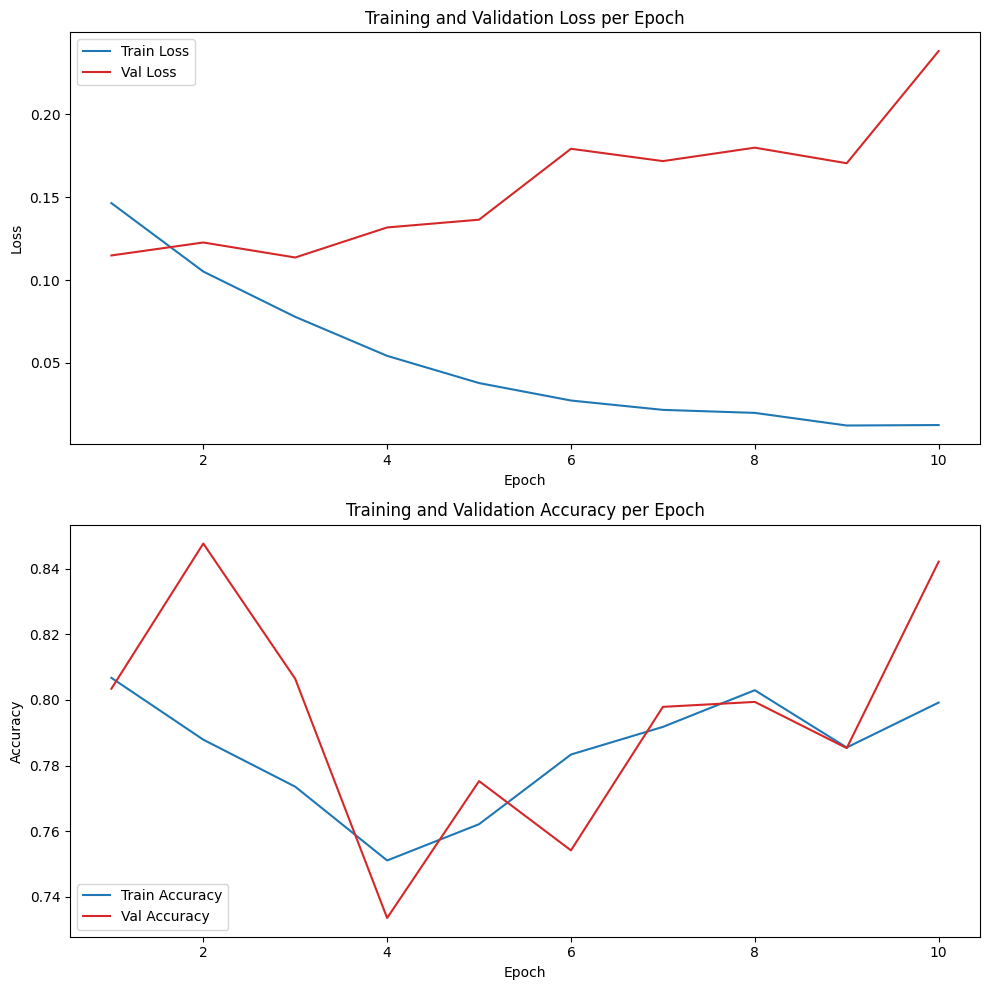

In [24]:
# Plot training history

epochs = range(1, len(train_stats) + 1)
train_losses = [entry[0] for entry in train_stats]
train_accuracies = [entry[1] for entry in train_stats]
val_losses = [entry[0] for entry in val_stats]
val_accuracies = [entry[1] for entry in val_stats]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

train_colour = 'tab:blue'
val_colour = 'tab:red'
# Plotting loss
ax1.plot(epochs, train_losses, label='Train Loss', color=train_colour)
ax1.plot(epochs, val_losses, label='Val Loss', color=val_colour)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss per Epoch')
ax1.legend()

# Plot accuracy
ax2.plot(epochs, train_accuracies, label='Train Accuracy', color=train_colour)
ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=val_colour)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy per Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

In [25]:
# Show the model's predictions on a random image from the test set

import numpy as np
import matplotlib.pyplot as plt
import random

random_img_index = random.randint(0, len(val_set)-1)

data = val_set[random_img_index] #1606 a gudun

image, true_onehot = data[0], data[1]

class_names = [label for label in label_map.keys()]
image_label = onehot_to_labels(true_onehot, class_names)  # Extract strings of image label(s)

# Generate prediction
model.eval()
with torch.no_grad():
  input = image.unsqueeze(0)
  prediction = model(input).squeeze()

predicted_label = onehot_to_labels(prediction, class_names)

# Convert tensor image to numpy for plotting
img_np = np.transpose(image.numpy(), (1, 2, 0))

# Plot transformed image
plt.title("Transformed image")
plt.imshow(img_np)
plt.axis('off')
plt.show()

# Compare prediction and ground truth of the image
print(f"Raw prediction: {prediction}")
print(f"Ground truth: {true_onehot}")
print()
print(f"Predicted label: {predicted_label}")
print(f"True label: {image_label}")

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [26]:
# Evaulate model on test set (inference)

from tqdm import tqdm

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

model_predictions = []
true_labels = []

with torch.no_grad():
  for data in tqdm(val_set):
      inputs, labels = data
      inputs = inputs.unsqueeze(0).to(device)   # Add batch dimension and move to device
      labels = labels.to(device)                # Move labels to device

      output = model(inputs)
      predictions = (output > 0.5).float()      # Threshold value of 0.5

      model_predictions.append(predictions.cpu().detach().numpy())
      true_labels.append(labels.cpu().detach().numpy())

model_predictions = np.squeeze(np.array(model_predictions), axis=1)
true_labels = np.array(true_labels)


100%|██████████| 1989/1989 [00:19<00:00, 104.50it/s]


In [27]:
# make homemade functions for calculating accuracy

def calculate_label_accuracy(true_labels, model_predictions):

    ''' Have found out this is Hamming score in multi-label scenarios: https://wiki.cloudfactory.com/docs/mp-wiki/metrics/hamming-score  '''

    # Convert lists of tensors to numpy arrays
    true_labels_np = np.array([label.flatten() for label in true_labels])
    model_predictions_np = np.array([pred.flatten() for pred in model_predictions])

    # Flatten the arrays to ensure they are in a single dimension
    true_labels_flat = true_labels_np.flatten()
    model_predictions_flat = model_predictions_np.flatten()

    # Compute the number of correct predictions
    correct_predictions = np.sum(true_labels_flat == model_predictions_flat)

    # Compute the total number of predictions
    total_predictions = len(true_labels_flat)

    # Compute accuracy
    accuracy_score = correct_predictions / total_predictions

    return accuracy_score

def calculate_subset_accuracy(true_labels, model_predictions):

    ''' This is the same as the standard sklearn accuracy_score function '''

    # Convert lists of tensors to numpy arrays
    true_labels_np = np.array([label.flatten() for label in true_labels])
    model_predictions_np = np.array([pred.flatten() for pred in model_predictions])

    # Check if all labels are the same for each pair
    exact_matches = np.all(true_labels_np == model_predictions_np, axis=1)

    # Count the number of exact matches
    num_correct = np.sum(exact_matches)

    # Compute the total number of datapoints
    total_datapoints = len(true_labels_np)

    # Compute accuracy
    accuracy_score = num_correct / total_datapoints

    return accuracy_score


In [28]:
# compare label-based vs subset accuracy score (NB: thresholding applied to predictions during inference)

print(f"Label (hamming) accuracy = {calculate_label_accuracy(true_labels, model_predictions)}")
print(f"Subset accuracy = {calculate_subset_accuracy(true_labels, model_predictions)}")

# compare home-made accuracy vs metrics from external libraries

from sklearn.metrics import accuracy_score, hamming_loss
import keras

sklearn_accuracy = accuracy_score(true_labels, model_predictions)
print(f"sklearn accuracy: {sklearn_accuracy}")

sklearn_hamming = hamming_loss(true_labels, model_predictions)
print(f"sklearn (1 - hamming_loss): {1-sklearn_hamming}")

m = keras.metrics.CategoricalAccuracy()
m.update_state(true_labels, model_predictions)
keras_accuracy = m.result()
print(f"keras CategoricalAccuracy: {keras_accuracy}")

Label (hamming) accuracy = 0.9658119658119658
Subset accuracy = 0.8114630467571644
sklearn accuracy: 0.8114630467571644
sklearn (1 - hamming_loss): 0.9658119658119658
keras CategoricalAccuracy: 0.9542483687400818


Conclusions:  
- sklearn multiclass accuracy = subset accuracy  
- Label-based (overall) accuracy = hamming score (i.e. 1 - hamming loss)  
- No clue what keras CategoricalAccuracy is doing
- Will be going forward with bog standard sklearn accuracy_score going forward

Accuracy: 0.8114630467571644


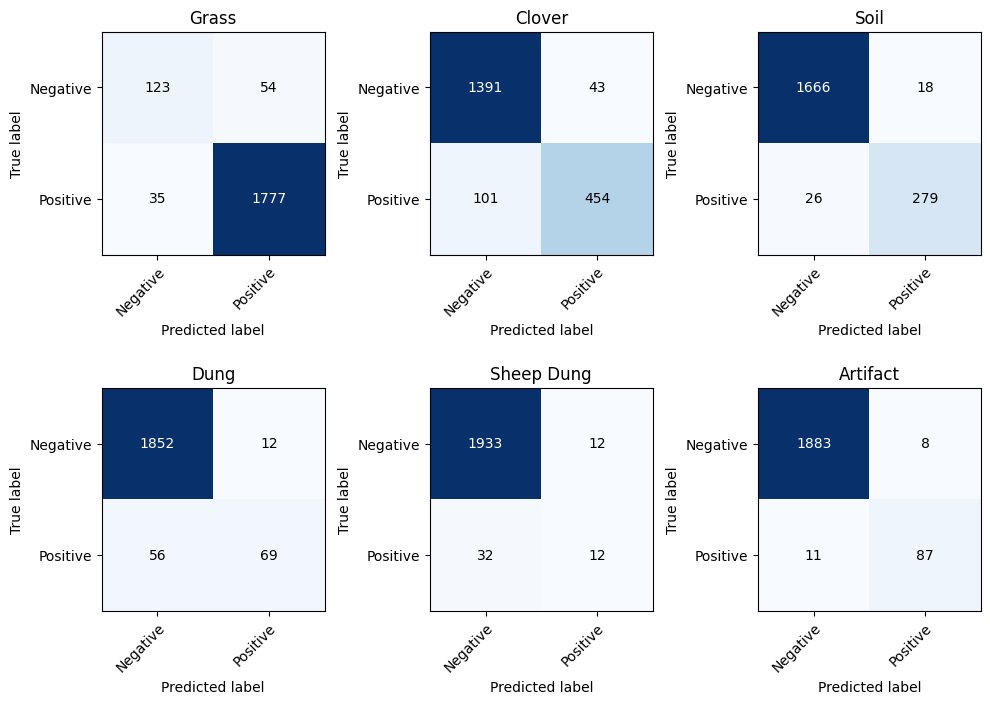

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix

class_names = [label for label in label_map.keys()]

accuracy = accuracy_score(true_labels, model_predictions)
confusion_matrices = multilabel_confusion_matrix(true_labels, model_predictions)

num_classes = len(class_names)
grid_size = int(np.ceil(np.sqrt(num_classes)))

fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(10, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
for i, (confusion_matrix, class_name) in enumerate(zip(confusion_matrices, class_names)):
    ax = axes[i]
    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(class_name)

    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(confusion_matrix.shape[1]),
           yticks=np.arange(confusion_matrix.shape[0]),
           xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for j in range(confusion_matrix.shape[0]):
        for k in range(confusion_matrix.shape[1]):
            ax.text(k, j, format(confusion_matrix[j, k], fmt),
                    ha="center", va="center",
                    color="white" if confusion_matrix[j, k] > thresh else "black")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
print(f"Accuracy: {accuracy}")
plt.show()
